<a href="https://colab.research.google.com/github/jasonihow/stock/blob/main/%E6%AD%A1%E8%BF%8E%E4%BD%BF%E7%94%A8_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 載入模組

In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import yfinance as yf

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
from tensorflow import keras
from tensorflow.keras import backend as clear
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

# Functions for evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from imblearn.metrics import sensitivity_score
from imblearn.metrics import specificity_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

用YahooFinance下載APPLE近十年的股票數據，每天會有五種數據:最高點、最低點、開盤價、收盤價、交易量

In [3]:
df = yf.Ticker("AAPL").history(period="10y")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2013-12-30 00:00:00-05:00,17.454301,17.536647,17.293365,17.362247,253629600,0.0,0.0
2013-12-31 00:00:00-05:00,17.351295,17.573911,17.345971,17.565771,223084400,0.0,0.0
2014-01-02 00:00:00-05:00,17.398573,17.440842,17.283977,17.318731,234684800,0.0,0.0
2014-01-03 00:00:00-05:00,17.310279,17.336578,16.921089,16.938311,392467600,0.0,0.0
2014-01-06 00:00:00-05:00,16.827783,17.120534,16.707237,17.030674,412610800,0.0,0.0
...,...,...,...,...,...,...,...
2023-12-22 00:00:00-05:00,195.179993,195.410004,192.970001,193.600006,37122800,0.0,0.0
2023-12-26 00:00:00-05:00,193.610001,193.889999,192.830002,193.050003,28919300,0.0,0.0
2023-12-27 00:00:00-05:00,192.490005,193.500000,191.089996,193.149994,48087700,0.0,0.0


數據的data type

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2518 entries, 2013-12-30 00:00:00-05:00 to 2023-12-29 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2518 non-null   float64
 1   High          2518 non-null   float64
 2   Low           2518 non-null   float64
 3   Close         2518 non-null   float64
 4   Volume        2518 non-null   int64  
 5   Dividends     2518 non-null   float64
 6   Stock Splits  2518 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 157.4 KB


只使用收盤價進行簡單的預測

In [5]:
df = df.filter(['Close'])
df

,Close
Date,
2013-12-30 00:00:00-05:00,17.362247
2013-12-31 00:00:00-05:00,17.565771
2014-01-02 00:00:00-05:00,17.318731
2014-01-03 00:00:00-05:00,16.938311
2014-01-06 00:00:00-05:00,17.030674
...,...
2023-12-22 00:00:00-05:00,193.600006
2023-12-26 00:00:00-05:00,193.050003
2023-12-27 00:00:00-05:00,193.149994


將十年內的收盤價畫成圖

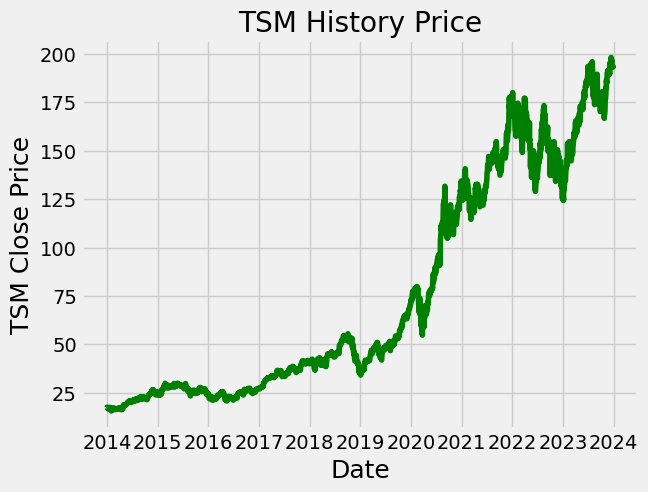

In [6]:
plt.style.use('fivethirtyeight')
plt.plot(df['Close'], color='green')
plt.ylabel('TSM Close Price', fontsize=18)
plt.title('TSM History Price')
plt.xlabel('Date', fontsize=18)

plt.show()

將數據標準化，把數據控制在0~1

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df.values)
scaled_data

array([[0.00939335],
       [0.01050879],
       [0.00915486],
       ...,
       [0.97281617],
       [0.97517288],
       [0.96941823]])

以前100天的收盤價去預測當天的收盤價，x_all為前100天的收盤價，y_all為要預測的收盤價

In [8]:
Forecast_days = 100

x_all,y_all = [], []
for i in range(len(scaled_data) - Forecast_days):
    x = scaled_data[i:i + Forecast_days]
    y = scaled_data[i + Forecast_days]
    x_all.append(x)
    y_all.append(y)

x_all, y_all = np.array(x_all), np.array(y_all)

x是三維的，y是二維的  (有幾組x, x的大小, 模型要用的值) (有幾組y, 模型要用的值)

In [9]:
x_all.shape, y_all.shape

((2418, 100, 1), (2418, 1))

將資料集的80%用來train 20%用來test

In [10]:
DS_split = 0.8

DS_train = round(x_all.shape[0] * DS_split)
x_train, y_train = x_all[:DS_train], y_all[:DS_train]
x_test, y_test = x_all[DS_train:], y_all[DS_train:]

In [11]:
x_train.shape, y_train.shape

((1934, 100, 1), (1934, 1))

In [12]:
x_test.shape, y_test.shape

((484, 100, 1), (484, 1))

構建模型

In [13]:
model = Sequential()
model.add(LSTM(75, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(35))
model.add(Dense(1))
opt=Adam(learning_rate=0.002,beta_1=0.95)
model.compile(optimizer=opt, loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 75)           23100     
                                                                 
 lstm_1 (LSTM)               (None, 50)                25200     
                                                                 
 dense (Dense)               (None, 35)                1785      
                                                                 
 dense_1 (Dense)             (None, 1)                 36        
                                                                 
Total params: 50121 (195.79 KB)
Trainable params: 50121 (195.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


訓練模型

In [14]:
early_stopping = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)   #透過early_stopping來找出validation loss最低的模型 如果10次(patience)內沒有出現更低的validation loss的話就停止訓練
history = model.fit(x_train, y_train, epochs = 1000, validation_split=0.2, callbacks=[early_stopping]) #最多跑1000回合(epochs) 將training set 分出20%作為validation set

Epoch 1/1000
49/49 [==============================] - 7s 31ms/step - loss: 0.0014 - val_loss: 8.9732e-04
Epoch 2/1000
49/49 [==============================] - 1s 13ms/step - loss: 1.2421e-04 - val_loss: 8.1341e-04
Epoch 3/1000
49/49 [==============================] - 1s 12ms/step - loss: 9.0362e-05 - val_loss: 0.0016
Epoch 4/1000
49/49 [==============================] - 1s 17ms/step - loss: 8.6121e-05 - val_loss: 0.0011
Epoch 5/1000
49/49 [==============================] - 1s 16ms/step - loss: 7.3114e-05 - val_loss: 6.4937e-04
Epoch 6/1000
49/49 [==============================] - 1s 17ms/step - loss: 7.2342e-05 - val_loss: 9.7655e-04
Epoch 7/1000
49/49 [==============================] - 1s 18ms/step - loss: 7.3879e-05 - val_loss: 9.6286e-04
Epoch 8/1000
49/49 [==============================] - 1s 12ms/step - loss: 7.8088e-05 - val_loss: 6.7575e-04
Epoch 9/1000
49/49 [==============================] - 1s 12ms/step - loss: 7.0037e-05 - val_loss: 9.6743e-04
Epoch 10/1000
49/49 [==========

In [15]:
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'val_loss'])

將training loss和 validation loss 畫出來

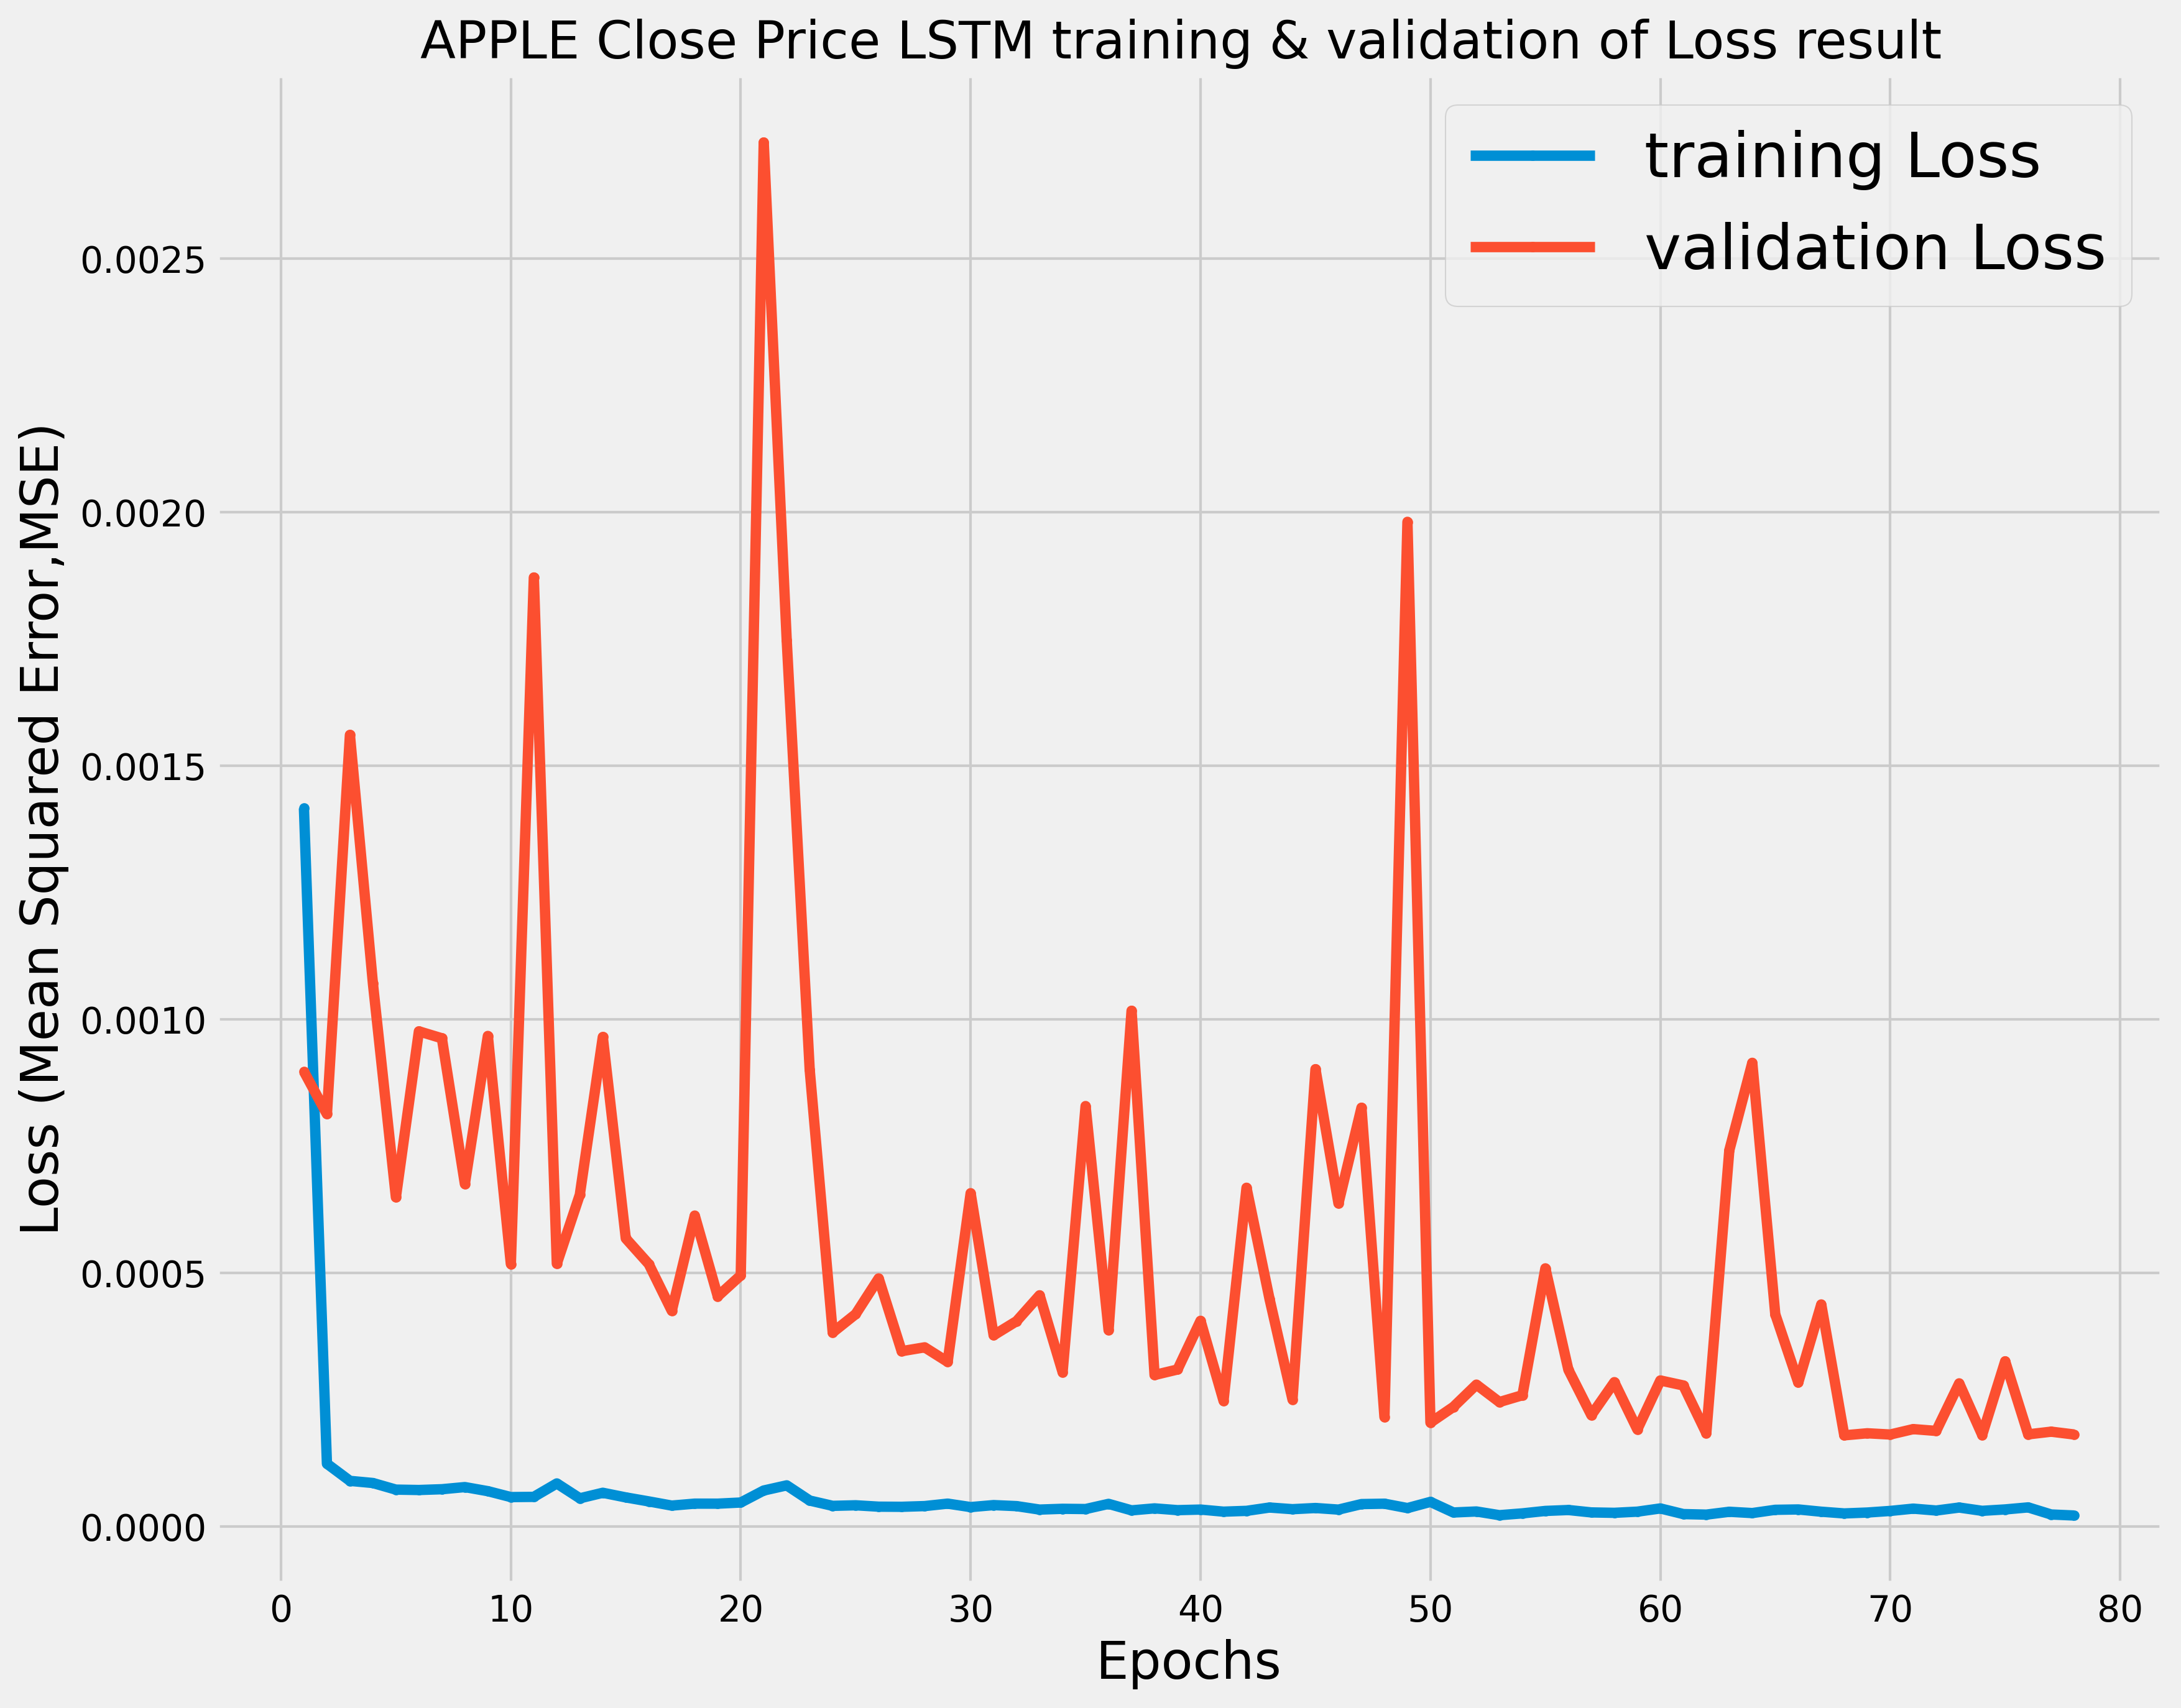

In [16]:
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Mean Squared Error,MSE)',fontsize=20)
plt.title('APPLE Close Price LSTM training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

模型預測

In [17]:
prediction= model.predict(x_test)
prediction

16/16 [==============================] - 1s 8ms/step


array([[0.77370137],
       [0.7714668 ],
       [0.83131564],
       [0.85999376],
       [0.85678643],
       [0.8612815 ],
       [0.8462135 ],
       [0.8450109 ],
       [0.8432856 ],
       [0.86193407],
       [0.8715092 ],
       [0.84770375],
       [0.82641107],
       [0.8279894 ],
       [0.8510338 ],
       [0.8505918 ],
       [0.8281008 ],
       [0.8174204 ],
       [0.8016494 ],
       [0.7782779 ],
       [0.7921092 ],
       [0.8058639 ],
       [0.80703634],
       [0.79508257],
       [0.8120126 ],
       [0.8121884 ],
       [0.7947734 ],
       [0.7728489 ],
       [0.7628839 ],
       [0.79394764],
       [0.77348757],
       [0.7494875 ],
       [0.7265573 ],
       [0.7501439 ],
       [0.77810824],
       [0.7844523 ],
       [0.80067706],
       [0.80873936],
       [0.8272319 ],
       [0.83606833],
       [0.8573454 ],
       [0.8622664 ],
       [0.86671895],
       [0.885836  ],
       [0.88033307],
       [0.86162186],
       [0.85960025],
       [0.883

將預測出來的數值轉化回來原本的股價

In [18]:
prediction = scaler.inverse_transform(prediction)
prediction

array([[156.81917 ],
       [156.41144 ],
       [167.33156 ],
       [172.56422 ],
       [171.979   ],
       [172.7992  ],
       [170.04985 ],
       [169.83041 ],
       [169.51562 ],
       [172.91826 ],
       [174.66534 ],
       [170.32176 ],
       [166.43666 ],
       [166.72466 ],
       [170.92937 ],
       [170.84872 ],
       [166.74498 ],
       [164.79622 ],
       [161.91861 ],
       [157.6542  ],
       [160.17789 ],
       [162.6876  ],
       [162.90152 ],
       [160.72041 ],
       [163.8095  ],
       [163.84157 ],
       [160.664   ],
       [156.66362 ],
       [154.8454  ],
       [160.51334 ],
       [156.78015 ],
       [152.40106 ],
       [148.21718 ],
       [152.52083 ],
       [157.62325 ],
       [158.7808  ],
       [161.7412  ],
       [163.21227 ],
       [166.58644 ],
       [168.19875 ],
       [172.081   ],
       [172.9789  ],
       [173.7913  ],
       [177.27943 ],
       [176.27536 ],
       [172.86128 ],
       [172.49242 ],
       [176.9

藍線是training的收盤價，橘線是test set裡已知的收盤價，綠線則是我們預測出來的價格

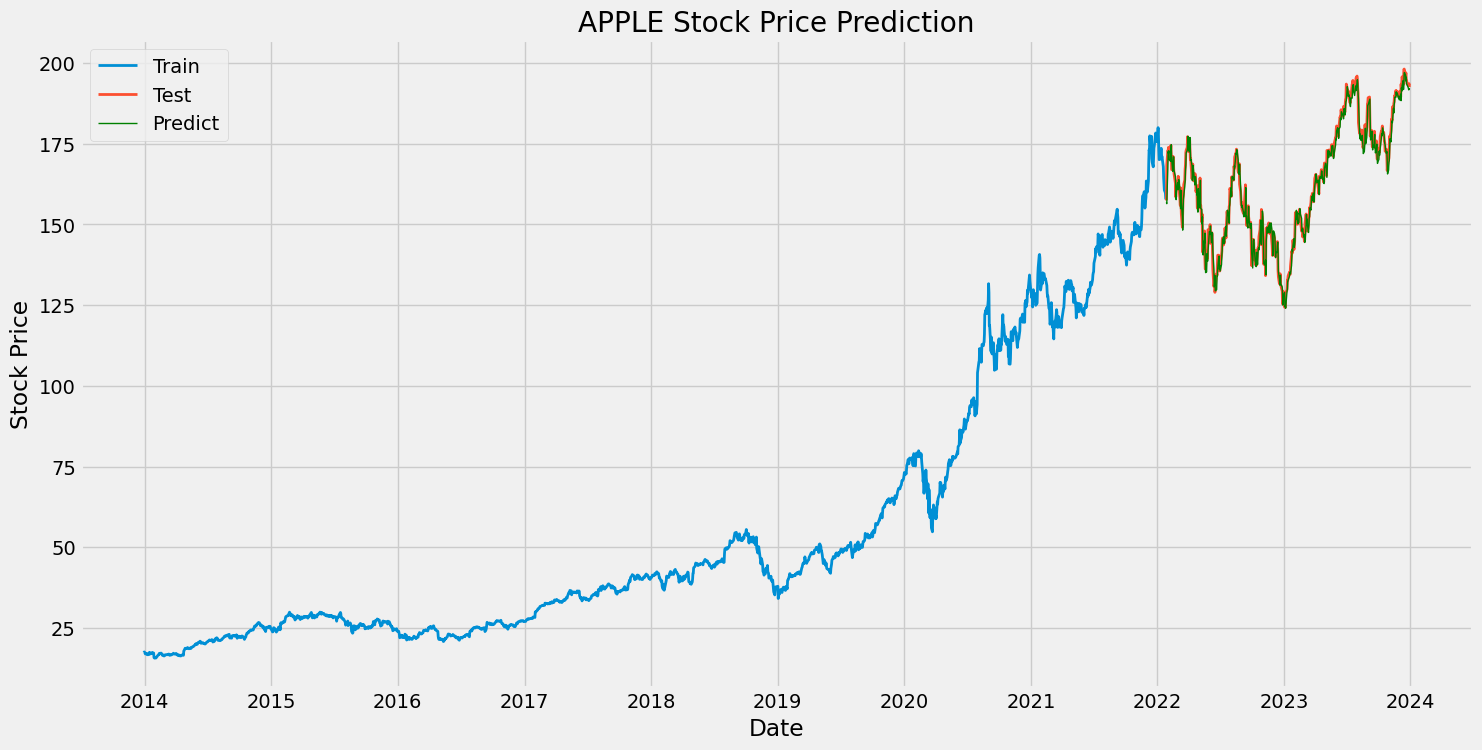

In [19]:
train_df = df[:DS_train + Forecast_days]
test_df = df[DS_train + Forecast_days:]
test_df = test_df.assign(Predict = prediction)

plt.figure(figsize=(16,8))
plt.plot(train_df['Close'], linewidth = 2)
plt.plot(test_df['Close'], linewidth = 2)
plt.plot(test_df['Predict'], color='green', linewidth = 1)
plt.title('APPLE Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend(['Train', 'Test', 'Predict'])
plt.show()

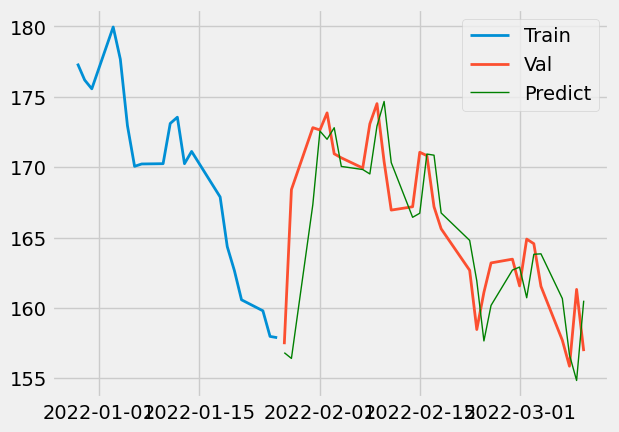

In [20]:
plt.plot(train_df['Close'][-20:], linewidth=2)
plt.plot(test_df['Close'][:30], linewidth = 2)
plt.plot(test_df['Predict'][:30], color='green', linewidth = 1)
plt.legend(['Train', 'Val', 'Predict'])
plt.show()

In [21]:
test_df = test_df.assign(Predict = prediction)
test_df


,Close,Predict
Date,,
2022-01-27 00:00:00-05:00,157.421326,156.819168
2022-01-28 00:00:00-05:00,168.405838,156.411438
2022-01-31 00:00:00-05:00,172.805573,167.331558
2022-02-01 00:00:00-05:00,172.637466,172.564224
2022-02-02 00:00:00-05:00,173.853577,171.979004
...,...,...
2023-12-22 00:00:00-05:00,193.600006,193.298355
2023-12-26 00:00:00-05:00,193.050003,192.256607
2023-12-27 00:00:00-05:00,193.149994,191.656662


In [22]:
rsme = mean_squared_error(test_df['Close'], test_df['Predict'], squared = False)
crmse = rsme / test_df['Close'].mean() * 100
rsme,crmse

(2.9507565410836203, 1.814592066106373)